# Import Library


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# Data Understanding


In [2]:
#Read Dataset
df = pd.read_csv(r'DataProduksi.csv')
df

,Tanggal,Minyak Sawit,Karet Kering,Teh
0,Jan-09,1427.10,50.00,8.80
1,Feb-09,1188.00,45.50,7.90
2,Mar-09,1346.70,40.10,8.50
3,Apr-09,1193.50,38.80,9.30
4,May-09,1239.50,47.20,10.30
...,...,...,...,...
115,Aug-18,2075.95,35.32,5.99
116,Sep-18,2093.69,49.37,6.78
117,Oct-18,2075.70,51.21,8.12
118,Nov-18,1931.94,48.77,8.48


In [3]:
# Melihat tipe data setiap kolom datanya
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Tanggal       120 non-null    object 
 1   Minyak Sawit  120 non-null    float64
 2   Karet Kering  120 non-null    float64
 3   Teh           120 non-null    float64
dtypes: float64(3), object(1)
memory usage: 3.9+ KB


In [4]:
#Memisahkan Kolom Dataframe Kedalam Variabel Terpisah

dates = df['Tanggal'].values
minyak_sawit = df['Minyak Sawit'].values
karet_kering = df['Karet Kering'].values
teh = df['Teh'].values

## Split Dataset


In [5]:
def split_data(X, y, split_percentage):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_percentage, shuffle=False)
    return X_train, X_test, y_train, y_test

## Normalsasi

In [6]:
scaler = MinMaxScaler()
def normalization(data):
    return scaler.fit_transform(data.reshape(-1, 1))


def to_original_value(data):
    return scaler.inverse_transform(data.reshape(-1, 1))

## Generate R2 Score


In [7]:
# Evaluasi model

def generate_r2(y_test, y_pred):
    r2 = r2_score(y_test,y_pred)
    print("R2 score: {:.2%}".format(r2))

## Generate Plot

In [8]:
# Untuk membuat grafik perbandingan antara data prediksi dengan data aktual

def generate_plot(X_data, y_data, X_name, y_name, attribute_name):
    plt.figure(figsize=(10, 6))
    plt.plot(X_data, label=X_name)
    plt.plot(y_data, label=y_name)
    plt.title(f'{X_name} vs {y_name} {attribute_name}')
    plt.xlabel('Bulan')
    plt.ylabel('Nilai Produksi')
    plt.legend()
    plt.show()
    print('\n')

## Generate LSTM Prediction

In [9]:
# Untuk memprediksi beberapa bulan kedepan

def predict_lstm(model, data, num_features, num_months):
    data_norm = normalization(data)
    input_seq = data_norm[-num_features:]
    future_preds_norm = []
    for i in range(num_months):
        pred_norm = model.predict(input_seq.reshape(1, -1))
        future_preds_norm.append(pred_norm[0])
        input_seq = np.append(input_seq[1:], pred_norm)
    future_preds = to_original_value(np.array(future_preds_norm))
    return future_preds


# LSTM model


In [10]:
def model_lstm(data, attribute_name, split_percentage=0.2, epochs=50, activation='relu'):
    X_train, X_test, y_train, y_test = split_data(normalization(data), normalization(data), split_percentage)

    model = Sequential([
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(30, activation),
        Dense(10, activation),
        Dense(1)
    ])
    model.compile(loss="mae", optimizer=Adam() , metrics=["mae"])
    model.fit(tf.expand_dims(X_train, axis=-1), tf.expand_dims(y_train, axis=-1), epochs=epochs, verbose=2)


    y_pred = model.predict(X_test)
    train_pred = model.predict(X_train)

    generate_r2(y_test, y_pred)

    generate_plot(to_original_value(y_test), to_original_value(y_pred), 'Data Test', 'Data Prediksi', attribute_name)
    generate_plot(to_original_value(X_train), to_original_value(train_pred), 'Data Training','Data Prediksi', attribute_name)

    num_months = [2, 5]
    for n in num_months:
        future_preds = predict_lstm(model, minyak_sawit, 12, n)
        print(f"Prediksi {n} bulan ke depan: {future_preds}")

# LSTM Evaluation


## Minyak Sawit


Epoch 1/1000


3/3 - 8s - loss: 1.0721 - mae: 1.0721 - 8s/epoch - 3s/step
Epoch 2/1000
3/3 - 0s - loss: 1.0200 - mae: 1.0200 - 18ms/epoch - 6ms/step
Epoch 3/1000
3/3 - 0s - loss: 0.9684 - mae: 0.9684 - 18ms/epoch - 6ms/step
Epoch 4/1000
3/3 - 0s - loss: 0.9172 - mae: 0.9172 - 19ms/epoch - 6ms/step
Epoch 5/1000
3/3 - 0s - loss: 0.8664 - mae: 0.8664 - 18ms/epoch - 6ms/step
Epoch 6/1000
3/3 - 0s - loss: 0.8162 - mae: 0.8162 - 16ms/epoch - 5ms/step
Epoch 7/1000
3/3 - 0s - loss: 0.7661 - mae: 0.7661 - 19ms/epoch - 6ms/step
Epoch 8/1000
3/3 - 0s - loss: 0.7167 - mae: 0.7167 - 20ms/epoch - 7ms/step
Epoch 9/1000
3/3 - 0s - loss: 0.6674 - mae: 0.6674 - 20ms/epoch - 7ms/step
Epoch 10/1000
3/3 - 0s - loss: 0.6184 - mae: 0.6184 - 19ms/epoch - 6ms/step
Epoch 11/1000
3/3 - 0s - loss: 0.5692 - mae: 0.5692 - 18ms/epoch - 6ms/step
Epoch 12/1000
3/3 - 0s - loss: 0.5211 - mae: 0.5211 - 17ms/epoch - 6ms/step
Epoch 13/1000
3/3 - 0s - loss: 0.4714 - mae: 0.4714 - 17ms/epoch - 6ms/step
Epoch 14/1000
3/3 - 0s - loss: 0.4225

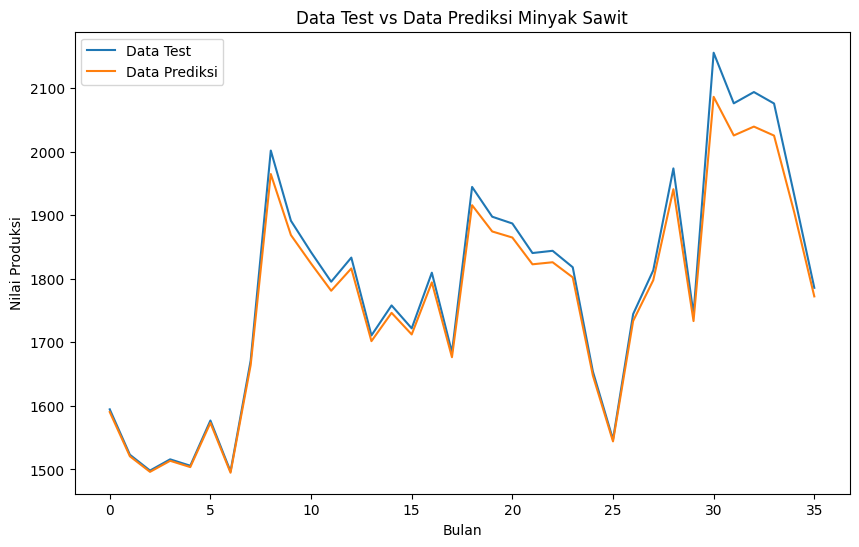

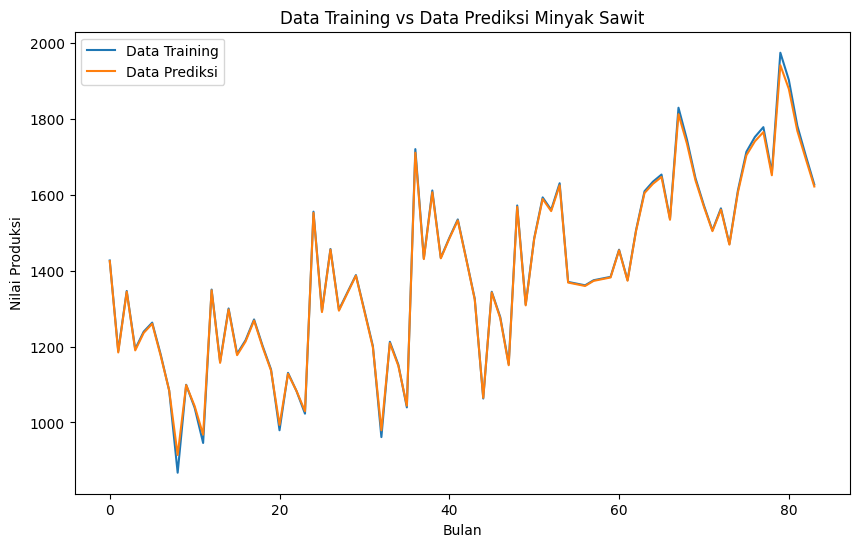



1/1 [==============================] - 0s 30ms/step
Prediksi 2 bulan ke depan: [[2556.065]
 [2556.424]]
1/1 [==============================] - 0s 29ms/step
Prediksi 5 bulan ke depan: [[2556.065 ]
 [2556.424 ]
 [2556.593 ]
 [2556.6848]
 [2556.7412]]


In [11]:
model_lstm(minyak_sawit, 'Minyak Sawit', 0.3, 1000, 'sigmoid')

## Karet Kering


Epoch 1/1000
3/3 - 9s - loss: 0.5393 - mae: 0.5393 - 9s/epoch - 3s/step
Epoch 2/1000
3/3 - 0s - loss: 0.4892 - mae: 0.4892 - 15ms/epoch - 5ms/step
Epoch 3/1000
3/3 - 0s - loss: 0.4392 - mae: 0.4392 - 1ms/epoch - 413us/step
Epoch 4/1000
3/3 - 0s - loss: 0.3894 - mae: 0.3894 - 16ms/epoch - 5ms/step
Epoch 5/1000
3/3 - 0s - loss: 0.3395 - mae: 0.3395 - 15ms/epoch - 5ms/step
Epoch 6/1000
3/3 - 0s - loss: 0.2901 - mae: 0.2901 - 45ms/epoch - 15ms/step
Epoch 7/1000
3/3 - 0s - loss: 0.2435 - mae: 0.2435 - 24ms/epoch - 8ms/step
Epoch 8/1000
3/3 - 0s - loss: 0.2006 - mae: 0.2006 - 22ms/epoch - 7ms/step
Epoch 9/1000
3/3 - 0s - loss: 0.1645 - mae: 0.1645 - 24ms/epoch - 8ms/step
Epoch 10/1000
3/3 - 0s - loss: 0.1364 - mae: 0.1364 - 23ms/epoch - 8ms/step
Epoch 11/1000
3/3 - 0s - loss: 0.1260 - mae: 0.1260 - 22ms/epoch - 7ms/step
Epoch 12/1000
3/3 - 0s - loss: 0.1216 - mae: 0.1216 - 29ms/epoch - 10ms/step
Epoch 13/1000
3/3 - 0s - loss: 0.1234 - mae: 0.1234 - 27ms/epoch - 9ms/step
Epoch 14/1000
3/3 - 0

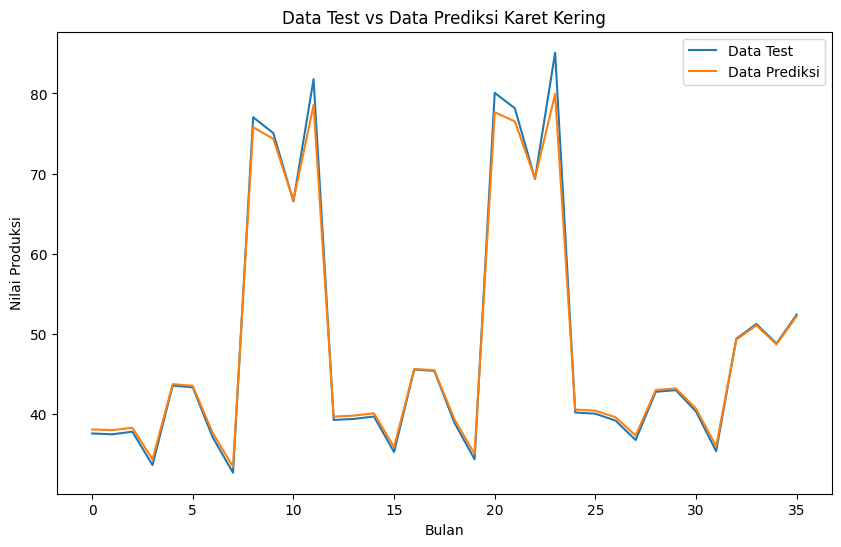

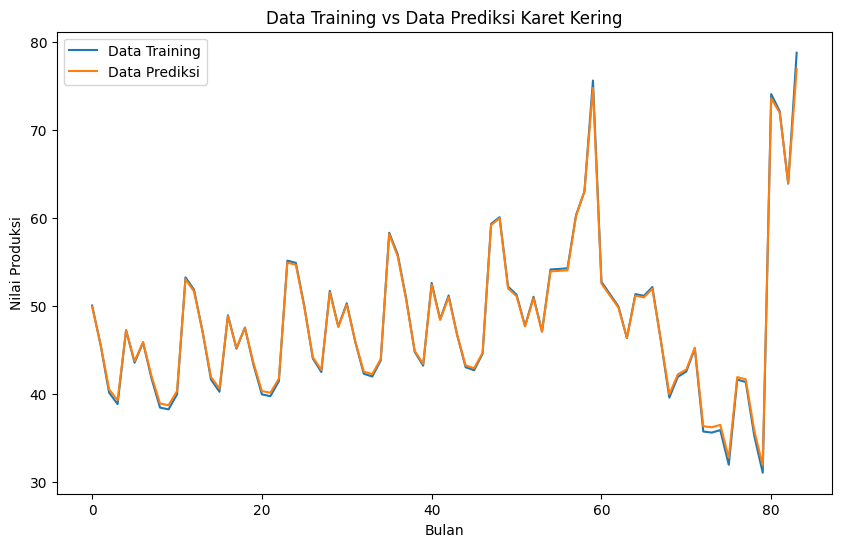



1/1 [==============================] - 0s 17ms/step
Prediksi 2 bulan ke depan: [[2119.667 ]
 [2119.6697]]
1/1 [==============================] - 0s 16ms/step
Prediksi 5 bulan ke depan: [[2119.667 ]
 [2119.6697]
 [2119.6714]
 [2119.6726]
 [2119.6733]]


In [12]:
model_lstm(karet_kering, 'Karet Kering', 0.3, 1000, 'sigmoid')


## Teh


Epoch 1/1000
3/3 - 7s - loss: 0.2749 - mae: 0.2749 - 7s/epoch - 2s/step
Epoch 2/1000
3/3 - 0s - loss: 0.2321 - mae: 0.2321 - 29ms/epoch - 10ms/step
Epoch 3/1000
3/3 - 0s - loss: 0.1981 - mae: 0.1981 - 4ms/epoch - 1ms/step
Epoch 4/1000
3/3 - 0s - loss: 0.1752 - mae: 0.1752 - 16ms/epoch - 5ms/step
Epoch 5/1000
3/3 - 0s - loss: 0.1691 - mae: 0.1691 - 16ms/epoch - 5ms/step
Epoch 6/1000
3/3 - 0s - loss: 0.1733 - mae: 0.1733 - 16ms/epoch - 5ms/step
Epoch 7/1000
3/3 - 0s - loss: 0.1769 - mae: 0.1769 - 16ms/epoch - 5ms/step
Epoch 8/1000
3/3 - 0s - loss: 0.1784 - mae: 0.1784 - 16ms/epoch - 5ms/step
Epoch 9/1000
3/3 - 0s - loss: 0.1774 - mae: 0.1774 - 16ms/epoch - 5ms/step
Epoch 10/1000
3/3 - 0s - loss: 0.1754 - mae: 0.1754 - 16ms/epoch - 5ms/step
Epoch 11/1000
3/3 - 0s - loss: 0.1713 - mae: 0.1713 - 16ms/epoch - 5ms/step
Epoch 12/1000
3/3 - 0s - loss: 0.1686 - mae: 0.1686 - 16ms/epoch - 5ms/step
Epoch 13/1000
3/3 - 0s - loss: 0.1679 - mae: 0.1679 - 16ms/epoch - 5ms/step
Epoch 14/1000
3/3 - 0s -

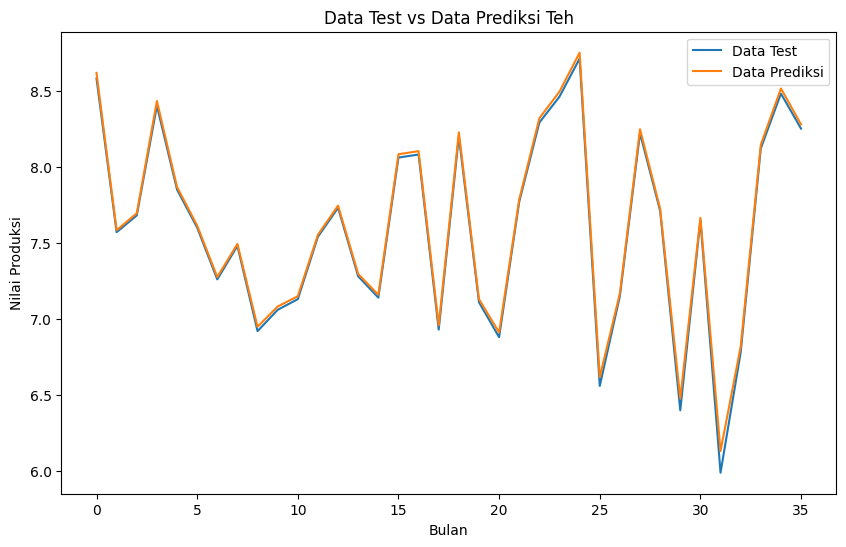

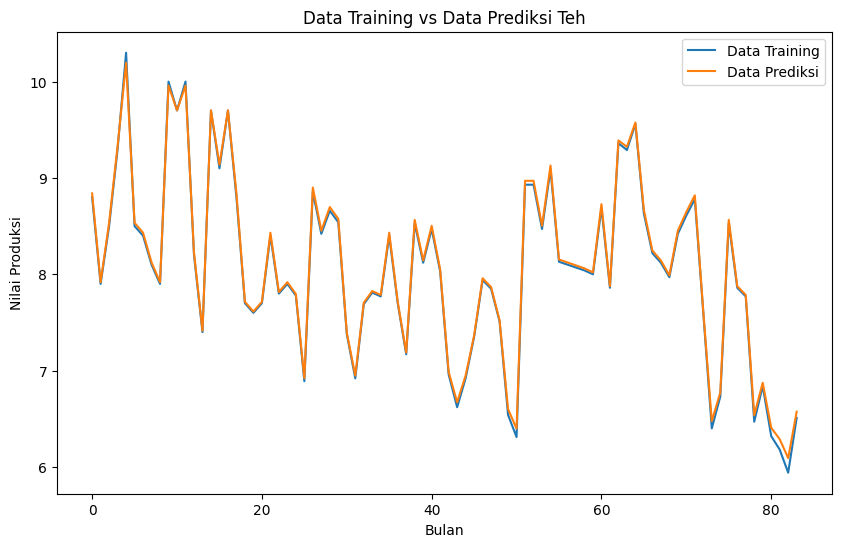



1/1 [==============================] - 0s 31ms/step
Prediksi 2 bulan ke depan: [[2639.786 ]
 [2640.0833]]
1/1 [==============================] - 0s 15ms/step
Prediksi 5 bulan ke depan: [[2639.786 ]
 [2640.0833]
 [2640.2476]
 [2640.2898]
 [2640.2876]]


In [13]:
model_lstm(teh, 'Teh', 0.3, 1000, 'sigmoid')


## Generate SVR Prediction  

In [14]:
def predict_future_svr(model, data, num_features, num_months):
    data_norm = normalization(data)
    input_seq = data_norm[-num_features:]
    future_preds_norm = []
    for i in range(num_months):
        pred_norm = model.predict(input_seq.reshape(1, -1))
        future_preds_norm.append(pred_norm[0])
        input_seq = np.append(input_seq[1:], pred_norm)
    return to_original_value(np.array(future_preds_norm))

# SVR Model


In [15]:
def model_svr(data, attribute_name, split_percentage=0.2, c=1000, gamma='scale', epsilon=0.1):
    X_train, X_test, y_train, y_test = split_data(normalization(data), normalization(data), split_percentage)


    model = SVR(kernel='rbf', C=c, gamma=gamma, epsilon=epsilon)
    model.fit(X_train.reshape(-1,1), y_train.ravel())
    

    y_pred = model.predict(X_test)
    train_pred = model.predict(X_train.reshape(-1,1))

    generate_r2(y_test, y_pred)

    generate_plot(to_original_value(y_test), to_original_value(y_pred), 'Data Test', 'Data Prediksi', attribute_name)
    generate_plot(to_original_value(X_train), to_original_value(train_pred), 'Data Training','Data Prediksi', attribute_name)

    num_months = [2, 3]
    for n in num_months:
        future_preds = predict_future_svr(model, minyak_sawit, 1, n)
        print(f"Prediksi {n} bulan ke depan: {future_preds}")

# SVR Evaluation


## Minyak Sawit


R2 score: 99.73%


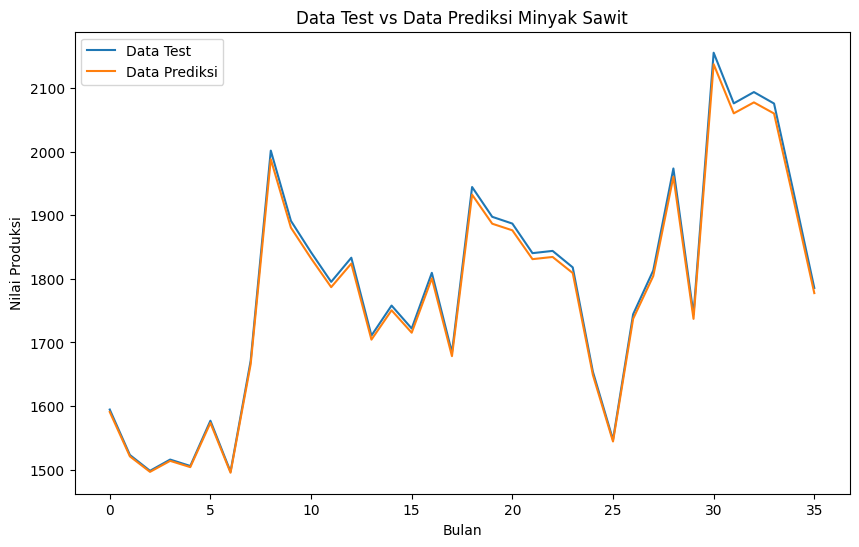

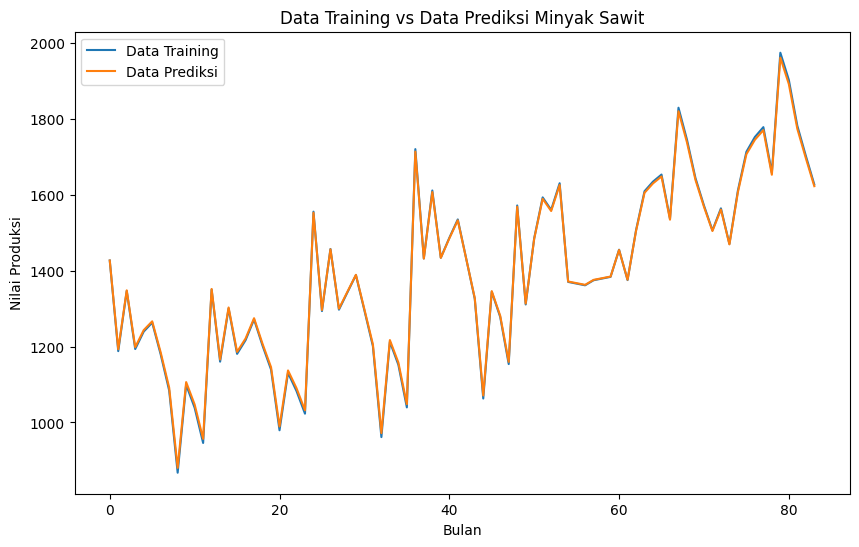



Prediksi 2 bulan ke depan: [[1777.6059426 ]
 [1769.69431103]]
Prediksi 3 bulan ke depan: [[1777.6059426 ]
 [1769.69431103]
 [1761.9697393 ]]


In [16]:
model_svr(minyak_sawit, 'Minyak Sawit', 0.3, 100, .01, .01)

## Karet Kering


R2 score: 99.96%


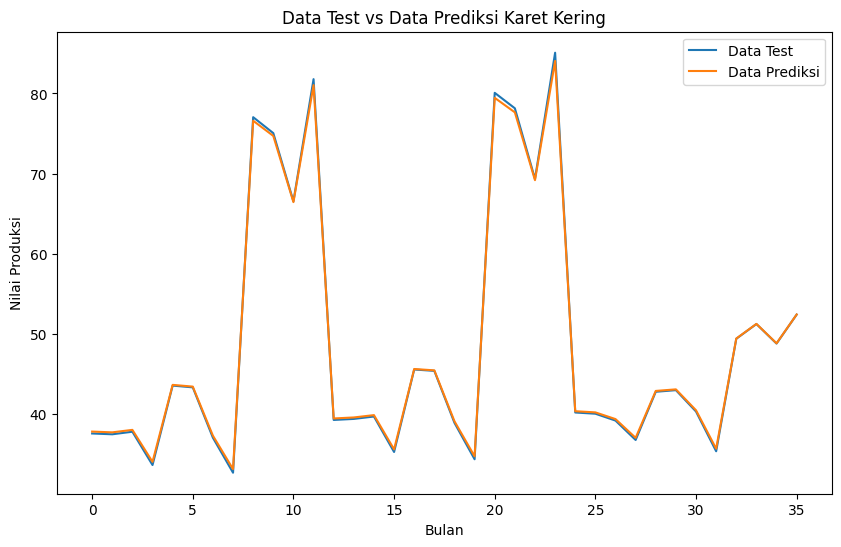

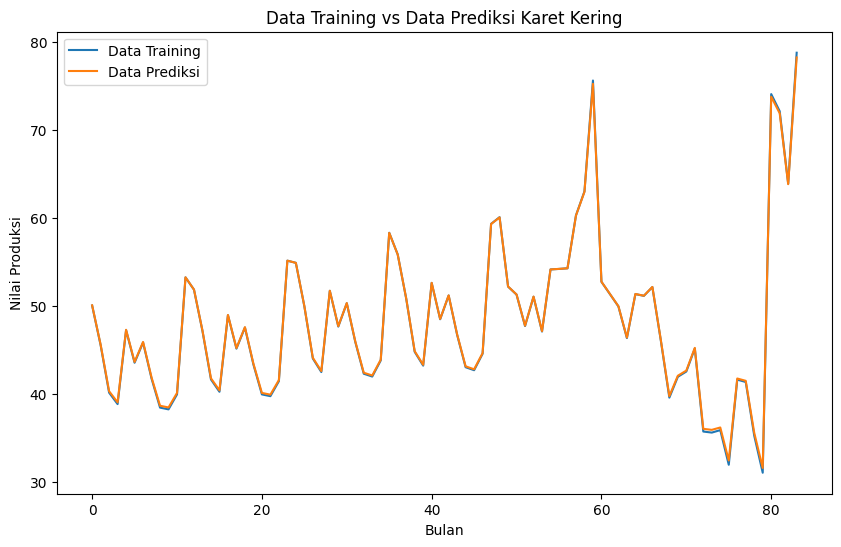



Prediksi 2 bulan ke depan: [[1781.88181444]
 [1778.14977455]]
Prediksi 3 bulan ke depan: [[1781.88181444]
 [1778.14977455]
 [1774.50974975]]


In [17]:
model_svr(karet_kering, 'Karet Kering', 0.3, 100, .1, .01)

## Teh


R2 score: 99.77%


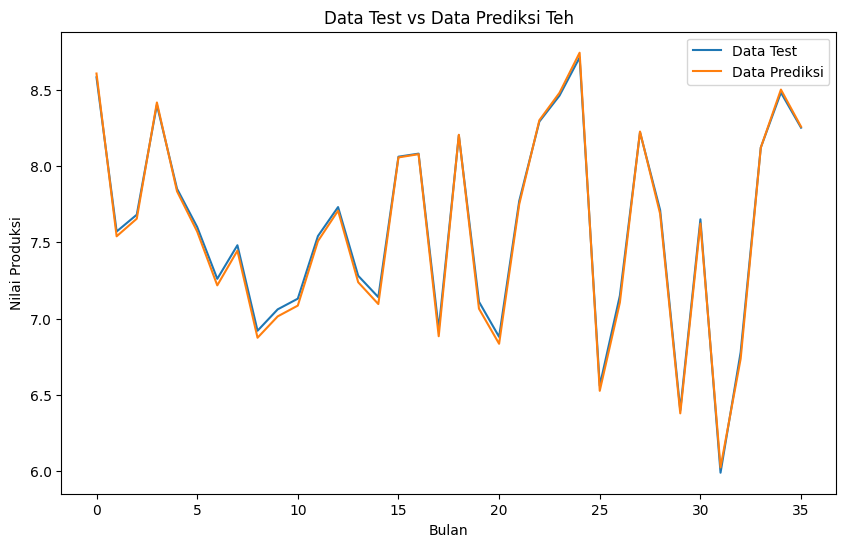

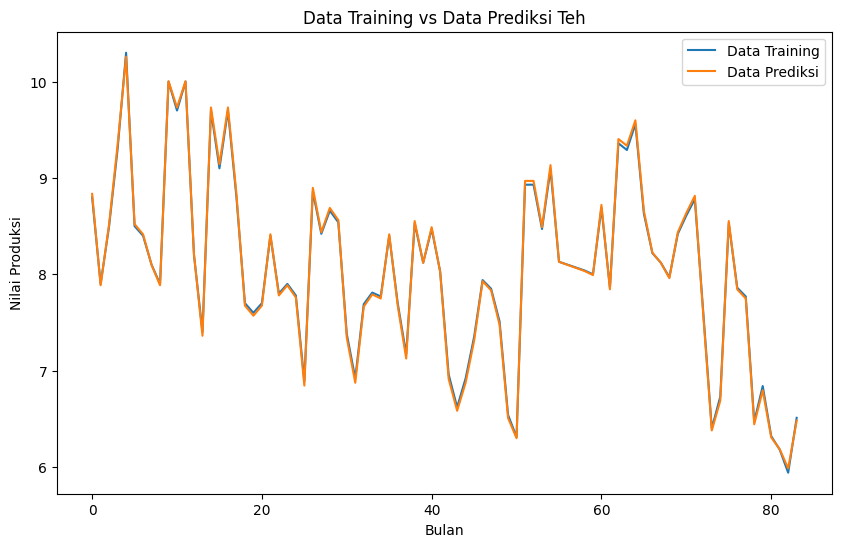



Prediksi 2 bulan ke depan: [[1798.22374616]
 [1810.97033388]]
Prediksi 3 bulan ke depan: [[1798.22374616]
 [1810.97033388]
 [1823.90338897]]


In [18]:
model_svr(teh, 'Teh', 0.3, 100, 1, .01)